# Introduction
The Vortex lattice method, also called VLM, is a numerical method used in computational fluid dynamics. VLM models a surface on aircraft as infinite vortices to estimate the lift curve slope, induced drag, and force distribution. The VLM is the extension of Prandtl’s lifting-line theory that is capable of computing swept and low aspect ratio wings.

## What is pySailingVLM?
**pySailingVLM** uses VLM method to determinate aerodynamic parameters such as CL, CD and lift-to-drag ratio for modeling behaviour of sailing yacht with different initial wind conditions. It is able to compute flat models as well as cambered ones. Users can experiment with theirs parameters to find the best sail geometry for given conditions. **pySailingVLM** is open source and available for every yacht lover. Package developers has updated VLM code to be faster and more efficient. This was achieved mainly by applying some compilations for specific functions in Python code using Numba which translates a subset of Python and NumPy code into fast machine code.

In cell below insert your initial parameters. If some of them are not required for your model, simply pass 0 value (for numbers). 
Some parameters are necessary only for specific cases like roughness (used by package when logarithmic profile is set) and they are omitted during computation. 

<div class="alert alert-block alert-warning"><b>ATTENTION:</b> do not delete keys in dictionaries and do not change their names. 
<br>
Make sure also that the length of your arrays match, like:  main_sail_girths and main_sail_chords</div>

More information can be found in code comments below.

In [1]:
# varaibles.py for jupyter
import os
import numpy as np
import time

# OUTPUT DIR
output_dir = {
    'case_dir':  os.path.abspath(''),  # get name of the current file
    'name': os.path.join("results_example_jib_and_mainsail_vlm", time.strftime("%Y-%m-%d_%Hh%Mm%Ss")),
    'file_name': 'my_fancy_results', # name of xlsx excel file
}

# SOLVER SETTINGS
solver = {
    'n_spanwise':  10,  # No of control points (above the water) per sail, recommended: 50
    'n_chordwise': 5, # No of control points (above the water) per sail, recommended: 50
    'interpolation_type': "spline",  # either "spline" or "linear"
    'LLT_twist': "real_twist",  # defines how the Lifting Line discretize the sail twist.
    # It can be "sheeting_angle_const" or "average_const" or "real_twist"
}

# SAILING CONDITIONS
conditions = {
    'leeway_deg': 5.,    # [deg]
    'heel_deg': 10.,     # [deg]
    'SOG_yacht': 4.63,   # [m/s] yacht speed - speed over ground (leeway is a separate variable)
    'tws_ref': 4.63,     # [m/s] true wind speed
    'alpha_true_wind_deg': 50.,   # [deg] true wind angle (with reference to course over ground) => Course Wind Angle to the boat track = true wind angle to centerline + Leeway
    'reference_water_level_for_wind_profile': -0.,  # [m] this is an attempt to mimick the deck effect
    # by lowering the sheer_above_waterline
    # while keeping the wind profile as in original geometry
    # this shall be negative (H = sail_ctrl_point - water_level)
    'wind_exp_coeff': 0.1428,  # [-] coefficient to determine the exponential wind profile
    'wind_reference_measurment_height': 10.,  # [m] reference height for exponential wind profile
    'rho': 1.225,  # air density [kg/m3]
    'wind_profile': 'exponential', # allowed: 'exponential' or 'flat' or 'logarithmic'
    'roughness': 0.05, # for logarithmic profile only, not taken into account if athe profile is used
}


# GEOMETRY OF THE RIG
rig = {
    'main_sail_luff': 12.4,  # [m]
    'jib_luff': 10.0,  # [m]
    'foretriangle_height': 11.50,  # [m]
    'foretriangle_base': 3.90,  # [m]
    'sheer_above_waterline': 1.2,#[m]
    'boom_above_sheer': 1.3, # [m],
    'rake_deg': 92.,  # rake angle [deg]
    'mast_LOA': 0.15,  # [m]
    'sails_def': 'jib_and_main', # definition of sail set, possible: 'jib' or 'main' or 'jib_and_main'
    'main_sail_girths': np.array([0.00, 1./8, 1./4, 1./2, 3./4, 7./8, 1.00]),
    'jib_girths': np.array([0.00, 1./4, 1./2, 3./4, 1.00]),
}

# INPUT - GEOMETRY OF THE SAIL
# INFO for camber:
# First digit describing maximum camber as percentage of the chord.
# Second digit describing the distance of maximum camber from the airfoil leading edge in tenths of the chord.

main_sail = {
    'main_sail_chords': np.array([4.00, 3.82, 3.64, 3.20, 2.64, 2.32, 2.00]),
    'main_sail_centerline_twist_deg': 12. * rig['main_sail_girths'] + 5., 
    'main_sail_camber': 5*np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01]),
    'main_sail_camber_distance_from_luff': np.array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]), # starting from leading edge
}


jib_sail = {
    'jib_chords': np.array([3.80, 2.98, 2.15, 1.33, 0.5]),
    'jib_centerline_twist_deg': 15. * rig['jib_girths'] + 7, 
    'jib_sail_camber': 0*np.array([0.01, 0.01, 0.01, 0.01, 0.01]),
    'jib_sail_camber_distance_from_luff': np.array([0.5, 0.5, 0.5, 0.5, 0.5]), # starting from leading edge   
}

# REFERENCE CSYS
# The origin of the default CSYS is located @ waterline level and aft face of the mast
# The positive x-coord: towards stern
# The positive y-coord: towards leeward side
# The positive z-coord: above the water
# To shift the default CSYS, adjust the 'reference_level_for_moments' variable.
# Shifted CSYS = original + reference_level_for_moments
# As a results the moments will be calculated around the new origin.

# yaw_reference [m] - distance from the aft of the mast towards stern, at which the yawing moment is calculated.
# sway_reference [m] - distance from the aft of the mast towards leeward side. 0 for symmetric yachts ;)
# heeling_reference [m] - distance from the water level,  at which the heeling moment is calculated.
csys = {
    'reference_level_for_moments': np.array([0, 0, 0]),  # [yaw_reference, sway_reference, heeling_reference]
}

# GEOMETRY OF THE KEEL
# to estimate heeling moment from keel, does not influence the optimizer.
# reminder: the z coord shall be negative (under the water)
keel = {
    'center_of_lateral_resistance_upright': np.array([0, 0, -1.0]),  # [m] the coordinates for a yacht standing in upright position
}


<div class="alert alert-block alert-warning">
<b>Run cell below twice:</b> Run cell below twice before running other cells. Output below is expected to always appear at first time importing pySailingVLM:
<br><br>
    
<em>   
/home/user/miniconda3/envs/mgr_test/lib/python3.10/site-packages/numba/core/lowering.py:107: NumbaDebugInfoWarning: Could not find source for function: <function __numba_array_expr_0x7f01d6a1e9e0 at 0x7f01d6cfa680>. Debug line information may be inaccurate.warnings.warn(NumbaDebugInfoWarning(msg))
</em> 
<br>
</div>

In [2]:
import shutil
from pySailingVLM.rotations.csys_transformations import CSYS_transformations
from pySailingVLM.yacht_geometry.hull_geometry import HullGeometry
from pySailingVLM.results.save_utils import save_results_to_file
from pySailingVLM.solver.panels_plotter import display_panels_xyz_and_winds
from pySailingVLM.results.inviscid_flow import InviscidFlowResults
from pySailingVLM.solver.coefs import get_vlm_Cxyz
from pySailingVLM.solver.vlm import Vlm
from pySailingVLM.runner.sail import Wind, Sail

from pySailingVLM.solver.panels_plotter import plot_cp

In [3]:
csys_transformations = CSYS_transformations(conditions['heel_deg'], conditions['leeway_deg'],
                                            v_from_original_xyz_2_reference_csys_xyz=csys['reference_level_for_moments'])
w = Wind(conditions)
s = Sail(solver, rig, main_sail, jib_sail, csys_transformations)

hull = HullGeometry(rig['sheer_above_waterline'], rig['foretriangle_base'], csys_transformations, keel['center_of_lateral_resistance_upright'])
myvlm = Vlm(s.sail_set.panels, solver['n_chordwise'], solver['n_spanwise'], conditions['rho'], w.profile, s.sail_set.trailing_edge_info, s.sail_set.leading_edge_info)

inviscid_flow_results = InviscidFlowResults(s.sail_set, csys_transformations, myvlm)
inviscid_flow_results.estimate_heeling_moment_from_keel(hull.center_of_lateral_resistance)

Applying initial_sail_twist_deg to jib -  Lifting Line, mode: real_twist
Applying initial_sail_twist_deg to main_sail -  Lifting Line, mode: real_twist
Applying initial_sail_twist_deg to jib -  Lifting Line, mode: real_twist
Applying initial_sail_twist_deg to main_sail -  Lifting Line, mode: real_twist
Applying initial_sail_twist_deg to jib -  Lifting Line, mode: real_twist
Applying initial_sail_twist_deg to main_sail -  Lifting Line, mode: real_twist
Applying initial_sail_twist_deg to jib -  Lifting Line, mode: real_twist
Applying initial_sail_twist_deg to main_sail -  Lifting Line, mode: real_twist


Cell below displays computations and saves integrals to output file.
<div class="alert alert-block alert-info">
<b>Tip:</b> For proper rendering of matplotlib figures in jupyter notebooks insert <em>%matplotlib widget</em> before calling plot functions.
</div>

Preparing visualization.


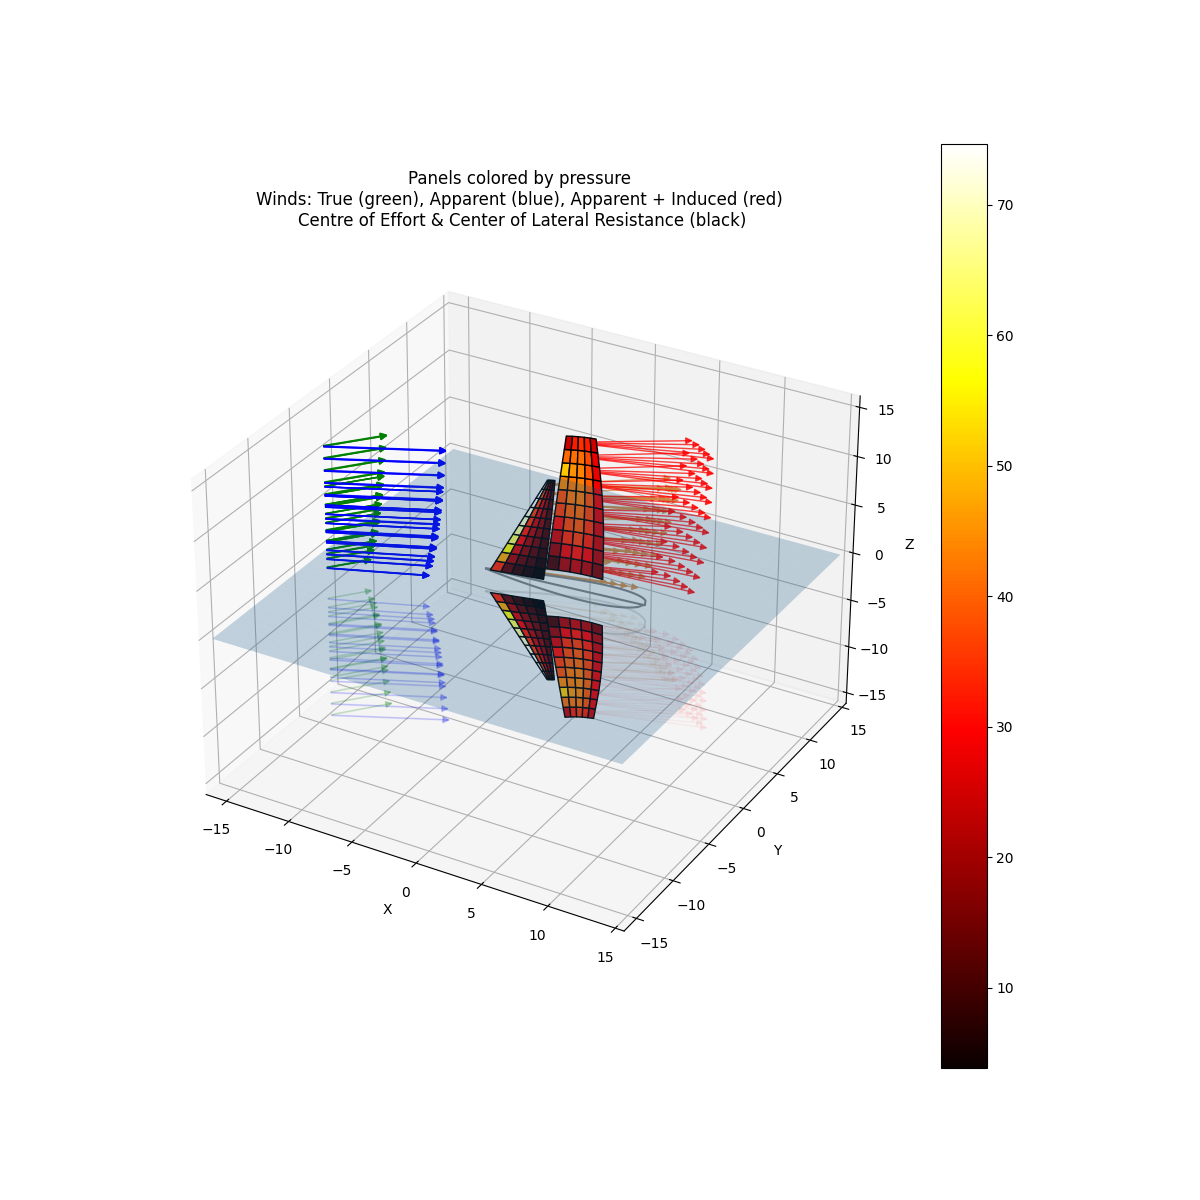

Applying initial_sail_twist_deg to jib -  Lifting Line, mode: real_twist
Applying initial_sail_twist_deg to main_sail -  Lifting Line, mode: real_twist


In [4]:
%matplotlib widget
print("Preparing visualization.")   
display_panels_xyz_and_winds(myvlm, inviscid_flow_results, myvlm.inlet_conditions, hull, show_plot=True)
df_components, df_integrals, df_inlet_IC = save_results_to_file(myvlm, csys_transformations, inviscid_flow_results, s.sail_set, output_dir['name'], output_dir['file_name'])

Lets see our integrals :)

In [5]:
print(f"-------------------------------------------------------------")
print(f"Notice:\n"
  f"\tThe forces [N] and moments [Nm] are without profile drag.\n"
  f"\tThe the _COG_ CSYS is aligned in the direction of the yacht movement (course over ground).\n"
  f"\tThe the _COW_ CSYS is aligned along the centerline of the yacht (course over water).\n"
  f"\tNumber of panels (sail s.sail_set with mirror): {s.sail_set.panels.shape}")

df_integrals

-------------------------------------------------------------
Applying initial_sail_twist_deg to jib -  Lifting Line, mode: real_twist
Applying initial_sail_twist_deg to main_sail -  Lifting Line, mode: real_twist
Notice:
	The forces [N] and moments [Nm] are without profile drag.
	The the _COG_ CSYS is aligned in the direction of the yacht movement (course over ground).
	The the _COW_ CSYS is aligned along the centerline of the yacht (course over water).
	Number of panels (sail s.sail_set with mirror): (200, 4, 3)


,Quantity,Value
0,F_jib_total_COG.x,-202.265193
1,F_jib_total_COG.y,463.058278
2,F_jib_total_COG.z,-33.136625
3,F_main_sail_total_COG.x,-399.385144
4,F_main_sail_total_COG.y,1152.557561
5,F_main_sail_total_COG.z,-219.865275
6,F_sails_total_COG.x,-601.650337
7,F_sails_total_COG.y,1615.615839
8,F_sails_total_COG.z,-253.001900
9,F_sails_total_COW.x,-740.171074


Compute aerodynamic parameters:

In [6]:
S = 2*rig['main_sail_luff'] * main_sail['main_sail_chords'][0]
C_xyz = get_vlm_Cxyz(myvlm.force, np.array(w.profile.get_true_wind_speed_at_h(1.0)), conditions['rho'], S)
C_xyz

(-1.7831768311932592, 4.788377160150618, -8.292032947123064e-17)

Make model plot in 2D colored by pressure coefficients:

In [8]:
plot_cp(s.sail_set.zero_mesh, myvlm.p_coeffs, output_dir['name'])

Applying initial_sail_twist_deg to jib -  Lifting Line, mode: real_twist
Applying initial_sail_twist_deg to main_sail -  Lifting Line, mode: real_twist


Loading BokehJS ...

Thats all. Experiment and play with this code on your own.